<a href="https://colab.research.google.com/github/raghunadh-eva/eva6/blob/master/S6_ASSIGNMENT/BN_L1_LOGS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Basic setup block**


*   Load the required utils/libraries
*   Setup the transformations needed to load the data
*   Split the input data into train and test
*   Create the train and test data objects





In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, utils
%matplotlib inline
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
!pip install torchsummary
from torchsummary import summary
import numpy as np

In [2]:
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)),
                                       transforms.RandomRotation((-7.0,7.0),fill=(0))
                                       #Ideally use mean - adding #0 since MNIST dark pixels and no-information around the borders
                                       #transforms.ColorJitter(brightness = 0.1, contrast= 0.1, saturation = 0.1, hue =0.1),
                                       #transforms.Resize((28,28)) #should be before converting to Tensor logically
                                       ])
test_transforms  = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       #transforms.RandomRotation((-7.0,7.0),fill=(0,)), #Ideally use mean - adding #0 since MNIST dark pixels and no-information around the borders
                                       #transforms.ColorJitter(brightness = 0.1, contrast= 0.1, saturation = 0.1, hue =0.1)
                                       #transforms.Resize((28,28)) #should be before converting to Tensor logically
                                      ])

In [3]:
train = datasets.MNIST('./data', train=True,  download=True, transform=train_transforms)
test =  datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [4]:
#Always start with same random set everytime
SEED = 1

#Is GPU ?
cuda = torch.cuda.is_available()

print('CUDA Available?',cuda)

#what happens when SEED = 2 ?
torch.manual_seed(SEED)

#set the seed for GPU device as well
if cuda:
  torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
#Why change batch_size for CPU - since it should not matter

train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

test_loader  = torch.utils.data.DataLoader(test, **dataloader_args)


CUDA Available? True


**Visualize the input data with image standardization**


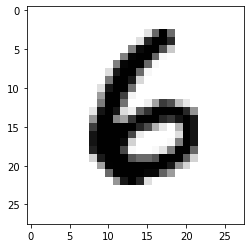

In [5]:
dataiter = iter(train_loader)


images, labels = dataiter.next()

#print(images[0])
#print(labels.shape)
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

**Visualize the input data without image standardization**



In [6]:
#Comment this block from CODE2 onwards
#train_nonorm_transforms = transforms.Compose([
#                                       transforms.ToTensor()
#                                       #transforms.Normalize((0.1307,), (0.3081,))
#                                       #transforms.RandomRotation((-7.0,7.0),fill=(0,)), #Ideally use mean - adding #0 since MNIST dark pixels and no-information around the borders
#                                       #transforms.ColorJitter(brightness = 0.1, contrast= 0.1, saturation = 0.1, hue =0.1),
#                                       #transforms.Resize((28,28)) #should be before converting to Tensor logically
#                                       ])
#test_nonorm_transforms  = transforms.Compose([
#                                       transforms.ToTensor()
#                                       #transforms.Normalize((0.1307,), (0.3081,))
#                                       #transforms.RandomRotation((-7.0,7.0),fill=(0,)), #Ideally use mean - adding #0 since MNIST dark pixels and no-information around the borders
#                                       #transforms.ColorJitter(brightness = 0.1, contrast= 0.1, saturation = 0.1, hue =0.1)
#                                       #transforms.Resize((28,28)) #should be before converting to Tensor logically
#                                      ])
#train_nonorm = datasets.MNIST('./data_nonorm', train=True,  download=True, transform=train_nonorm_transforms)
#test_nonorm =  datasets.MNIST('./data_nonorm', train=False, download=True, transform=test_nonorm_transforms)
#train_loader_nonorm = torch.utils.data.DataLoader(train_nonorm, **dataloader_args)
#test_loader_nonorm  = torch.utils.data.DataLoader(test_nonorm, **dataloader_args)
#dataiter_nonorm = iter(train_loader_nonorm)
#images, labels = dataiter_nonorm.next()
#print(images[0])
#print(labels.shape)
#
#plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

In [7]:
dropout_perc = 0.05

**####Batch Normalization + L1 LOSS**

In [8]:
class BatchNormNet(nn.Module):
    def __init__(self):
        super(BatchNormNet, self).__init__()

        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_perc)
        ) # output_size = 26 ; #Receptive field = 3x3

        #CT1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=18, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(18),
            nn.Dropout(dropout_perc)
        ) # output_size = 24; #Receptive field = 5x5

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=18, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24; #Receptive field = 5x5

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12 ; #Receptive field = 6x6

        #CT2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_perc)
        ) # output_size = 10 ;  #Receptive field = 10x10

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(20),            
            nn.Dropout(dropout_perc)
        ) # output_size = 8 ; #Receptive field = 14x14

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 8 ; #Receptive field = 14x14
     
        #CT3
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(3, 3), padding=0, bias=False), 
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_perc)          
        ) # output_size = 6 ; #Receptive field = 18x18
                 
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.gap(x)        
        x = self.convblock9(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

####LayerNorm Normalization + L1 LOSS

In [9]:
class LayerNormNet(nn.Module):
    def __init__(self):
        super(LayerNormNet, self).__init__()

        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.GroupNorm(1,10),
            nn.Dropout(dropout_perc)
        ) # output_size = 26 ; #Receptive field = 3x3

        #CT1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=18, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.GroupNorm(1,18),
            nn.Dropout(dropout_perc)
        ) # output_size = 24; #Receptive field = 5x5

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=18, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24; #Receptive field = 5x5

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12 ; #Receptive field = 6x6

        #CT2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.GroupNorm(1,16),
            nn.Dropout(dropout_perc)
        ) # output_size = 10 ;  #Receptive field = 10x10

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.GroupNorm(1,20),            
            nn.Dropout(dropout_perc)
        ) # output_size = 8 ; #Receptive field = 14x14

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 8 ; #Receptive field = 14x14
     
        #CT3
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(3, 3), padding=0, bias=False), 
            nn.ReLU(),
            nn.GroupNorm(1,32),
            nn.Dropout(dropout_perc)          
        ) # output_size = 6 ; #Receptive field = 18x18
                 
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.gap(x)        
        x = self.convblock9(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

**`####Group normalization network + L1 LOSS`**

In [10]:
class GroupNormNet(nn.Module):
    def __init__(self):
        super(GroupNormNet, self).__init__()

        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.GroupNorm(2,10),
            nn.Dropout(dropout_perc)
        ) # output_size = 26 ; #Receptive field = 3x3

        #CT1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=18, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.GroupNorm(3,18),
            nn.Dropout(dropout_perc)
        ) # output_size = 24; #Receptive field = 5x5

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=18, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24; #Receptive field = 5x5

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12 ; #Receptive field = 6x6

        #CT2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.GroupNorm(2,16),
            nn.Dropout(dropout_perc)
        ) # output_size = 10 ;  #Receptive field = 10x10

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.GroupNorm(2,20),            
            nn.Dropout(dropout_perc)
        ) # output_size = 8 ; #Receptive field = 14x14

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 8 ; #Receptive field = 14x14
     
        #CT3
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(3, 3), padding=0, bias=False), 
            nn.ReLU(),
            nn.GroupNorm(2,32),
            nn.Dropout(dropout_perc)          
        ) # output_size = 6 ; #Receptive field = 18x18
                 
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.gap(x)        
        x = self.convblock9(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [11]:
from tqdm import tqdm

test_fail_data = []
test_fail_target = []
test_losses = []
test_acc = []
train_acc = []
train_losses = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  
  l1_lamda = 0.0001
  
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    ##Add L1 Loss
    l1 = 0
    for p in model.parameters():
      p_tensor = torch.sum(torch.abs(p))
      l1 += p_tensor

    loss = loss + l1_lamda * l1
    
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    test_fail_data = []
    test_fail_target = []

    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            for i,x in enumerate(pred.eq(target.view_as(pred))):
              if not x:
                test_fail_data.append(data[i])
                test_fail_target.append(target[i])

    test_losses.append(test_loss)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

    return test_losses, test_acc, test_fail_data, test_fail_target;

In [12]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


**####Block to pass argment and call the Model**

Pass the model to be Invoked based on Input Argument

In [13]:
def main(input_model_type,EPOCHS):
  if input_model_type == 0:
    model = BatchNormNet().to(device)
    run_train_test(model,EPOCHS,input_model_type)
  elif input_model_type == 1:
    model = LayerNormNet().to(device)
    run_train_test(model,EPOCHS,input_model_type)
  elif input_model_type == 2:
    model = GroupNormNet().to(device)
    run_train_test(model,EPOCHS,input_model_type)
  else:
    print("Invalid input for input_model_type",input_model_type)
    print("Supported values are 0 = Batch Norm,1 = Layer Norm,2 = Group Norm")

def run_train_test(model,EPOCHS,input_model_type):
  summary(model, input_size=(1, 28, 28))
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

  for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    
    train(model, device, train_loader, optimizer, epoch)
    
    test_losses, test_acc, test_fail_data, test_fail_target = test(model, device, test_loader)
  
  #print(test_fail_data)
  fig, axs = plt.subplots(1, 2)
  if input_model_type == 0:
    fig.suptitle('Model Type: Batch normalization')
  if input_model_type == 1:
    fig.suptitle('Model Type: Layer normalization')
  if input_model_type == 2:
    fig.suptitle('Model Type: Group normalization')
  
  axs[0].set_title('Test/Validation Loss Graph')
  axs[0].set_xticks(np.arange(1,EPOCHS+1))
  #axs[0].xlabel('Test/Validation Loss Graph')
  #axs[0].ylabel('LOSS')
  axs[1].set_title('Test/Validation Accuracy Graph')
  axs[1].set_xticks(np.arange(1,EPOCHS+1))
  #axs[1].xlabel('Test/Validation Accuracy Graph')
  #axs[1].ylabel('Accuracy')
  
  axs[0].plot(test_losses)
  axs[1].plot(test_acc)

  test_10_images = []
  for i in range(0,10):
    test_10_images.append(test_fail_data[i])
  
  grid = torchvision.utils.make_grid(torch.stack(test_10_images).cpu(), nrow=5)
  plt.figure(figsize=(15,15))
  plt.imshow(np.transpose(grid, (1,2,0)))

**####Call to main function**

main(input_model_type,EPOCHS)

input_model_type:

Supported values are

0 = Train a model with Batch normalization

1 = Train a model with Layer normalization

2 = Train a model with Group Normalization

EPOCHS: num_epochs


  0%|          | 0/469 [00:00<?, ?it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 18, 24, 24]           1,620
              ReLU-6           [-1, 18, 24, 24]               0
       BatchNorm2d-7           [-1, 18, 24, 24]              36
           Dropout-8           [-1, 18, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             180
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1, 16,

Loss=0.18312972784042358 Batch_id=468 Accuracy=88.89: 100%|██████████| 469/469 [00:24<00:00, 19.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 873.8166, Accuracy: 9773/10000 (97.73%)

EPOCH: 1


Loss=0.09936152398586273 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:24<00:00, 19.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 588.5831, Accuracy: 9848/10000 (98.48%)

EPOCH: 2


Loss=0.11571905016899109 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:24<00:00, 19.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 426.6120, Accuracy: 9872/10000 (98.72%)

EPOCH: 3


Loss=0.10457572340965271 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:24<00:00, 19.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 441.4284, Accuracy: 9869/10000 (98.69%)

EPOCH: 4


Loss=0.1406230330467224 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:24<00:00, 18.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 321.8858, Accuracy: 9899/10000 (98.99%)

EPOCH: 5


Loss=0.09412409365177155 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:24<00:00, 19.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 312.9310, Accuracy: 9903/10000 (99.03%)

EPOCH: 6


Loss=0.11035487055778503 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:24<00:00, 19.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 300.7864, Accuracy: 9891/10000 (98.91%)

EPOCH: 7


Loss=0.07132939249277115 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:24<00:00, 18.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 261.2397, Accuracy: 9916/10000 (99.16%)

EPOCH: 8


Loss=0.13527819514274597 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:24<00:00, 19.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 280.9252, Accuracy: 9910/10000 (99.10%)

EPOCH: 9


Loss=0.10228127986192703 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:24<00:00, 19.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 317.0813, Accuracy: 9900/10000 (99.00%)

EPOCH: 10


Loss=0.15323127806186676 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:24<00:00, 18.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 348.1618, Accuracy: 9899/10000 (98.99%)

EPOCH: 11


Loss=0.13340432941913605 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:24<00:00, 18.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 295.0109, Accuracy: 9905/10000 (99.05%)

EPOCH: 12


Loss=0.08069297671318054 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:24<00:00, 18.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 299.3691, Accuracy: 9902/10000 (99.02%)

EPOCH: 13


Loss=0.1194080263376236 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:25<00:00, 18.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 237.4172, Accuracy: 9919/10000 (99.19%)

EPOCH: 14


Loss=0.08261546492576599 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:25<00:00, 18.67it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Test set: Average loss: 234.2332, Accuracy: 9929/10000 (99.29%)



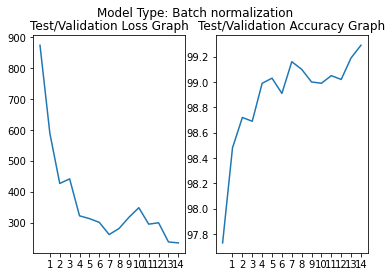

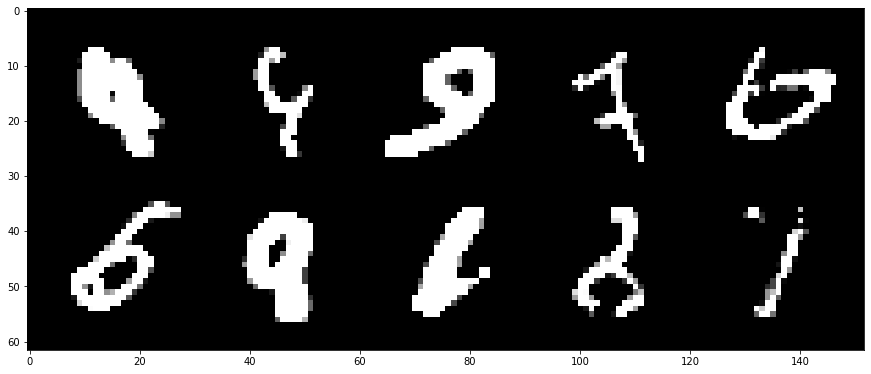

In [14]:
main(0,15)


In [15]:
#

#test_10_images = torch.stack(test_10_images)
#print(test_10_images.dtype)
##print(test_10_images)
#grid = torchvision.utils.make_grid(torch.stack(test_fail_data), nrow=5)
#plt.figure(figsize=(15,15))
#plt.imshow(np.transpose(grid, (1,2,0)))